In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )    

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [2]:
test = pd.read_csv(r'D:\ab_test.csv')

In [3]:
countries= pd.read_csv(r'D:\countries_ab.csv')

In [4]:
test.info

<bound method DataFrame.info of             id     time  con_treat      page  converted
0       851104  11:48.6    control  old_page          0
1       804228  01:45.2    control  old_page          0
2       661590  55:06.2  treatment  new_page          0
3       853541  28:03.1  treatment  new_page          0
4       864975  52:26.2    control  old_page          1
...        ...      ...        ...       ...        ...
294473  751197  28:38.6    control  old_page          0
294474  945152  51:57.1    control  old_page          0
294475  734608  45:03.4    control  old_page          0
294476  697314  20:29.0    control  old_page          0
294477  715931  40:24.5  treatment  new_page          0

[294478 rows x 5 columns]>

In [5]:
test.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
test.isna().sum()

id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

In [7]:
test.shape

(294478, 5)

In [8]:
test = test.rename(columns={'page':'landing_page','con_treat':'group'})
test

,id,time,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


In [9]:
#List of False/True for duplicated
test['id'].duplicated()
#Sum the values to get the the number of repeated user ids
sum(test['id'].duplicated())


3894

In [10]:
test[test.duplicated(['id'], keep=False)]['id']
test[test.duplicated(['id'], keep=False)]


,id,time,group,landing_page,converted
22,767017,58:15.0,control,new_page,0
192,656468,13:29.8,treatment,new_page,1
226,773693,05:45.2,control,old_page,1
240,733976,11:16.4,control,new_page,0
246,704650,10:52.7,treatment,new_page,0
...,...,...,...,...,...
294308,905197,56:47.5,treatment,new_page,0
294309,787083,15:21.0,control,old_page,0
294328,641570,59:27.7,control,old_page,0
294331,689637,34:28.3,control,new_page,0


In [11]:
test.drop(test.query("group == 'treatment' & landing_page == 'old_page'").index, inplace=True)
test.drop(test.query("group == 'control' & landing_page == 'new_page'").index, inplace=True)
test

,id,time,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


In [12]:
test['group'].value_counts()


treatment    145311
control      145274
Name: group, dtype: int64

In [13]:
# Double Check all of the correct rows were removed - this should be 0
print(test[((test['group'] == 'treatment') == (test['landing_page'] == 'new_page')) == False])
test[((test['group'] == 'treatment') == (test['landing_page'] == 'new_page')) == False].shape[0]


Empty DataFrame
Columns: [id, time, group, landing_page, converted]
Index: []


0

In [14]:
test_group = test.groupby('group')
test_group.describe()


id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    145274.0  788164.072594  91287.914601  630002.0  709279.5   
treatment  145311.0  787845.618446  91161.258854  630000.0  708746.5   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788128.5  867208.25  945998.0  145274.0  0.120386  0.325414  0.0   
treatment  787874.0  866718.50  945999.0  145311.0  0.118807  0.323563  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

In [15]:
#Find the individual who recieved the new page
recieved_new_page_users = len(test.query("group =='treatment'"))
print(recieved_new_page_users)

#Get the total number of users
total_users = test.shape[0]
print(total_users)

#Calculate the probability
new_user_prob = recieved_new_page_users/total_users
print(new_user_prob)


145311
290585
0.5000636646764286


In [16]:
p_new = test['converted'].mean()* 100
print(p_new)


11.959667567149026


In [17]:
p_old = test['converted'].mean()* 100
print(p_old)

11.959667567149026


In [96]:
#What is the probability that an individual received the new page?
pd.DataFrame(test['landing_page'].value_counts(normalize = True) * 100)


,landing_page
new_page,50.006366
old_page,49.993634


In [97]:
n_new = len(test.query("group == 'treatment'"))
print(n_new)

145311


In [98]:
n_old = len(test.query("group == 'control'"))
print(n_old)

145274


In [82]:
treatment_sample = test[test['group'] == "treatment"].sample(n=required_n, random_state=22) 
treatment_sample

,id,time,group,landing_page,converted
64980,691729,32:58.4,treatment,new_page,0
101974,813942,20:46.3,treatment,new_page,1
84427,810415,03:07.4,treatment,new_page,1
58018,793419,36:15.6,treatment,new_page,0
206942,721353,35:08.1,treatment,new_page,0
...,...,...,...,...,...
263919,688017,50:30.5,treatment,new_page,0
186349,914320,42:30.3,treatment,new_page,0
247698,808236,31:31.6,treatment,new_page,0
180179,911914,05:33.9,treatment,new_page,0


In [60]:
control_sample = test[test['group'] == "control"].sample(n=required_n, random_state=22) 
control_sample

,id,time,group,landing_page,converted
254532,644179,15:36.7,control,old_page,0
196706,729672,04:10.4,control,old_page,0
272726,866186,56:47.7,control,old_page,0
118044,884303,49:04.2,control,old_page,0
205159,882576,36:49.9,control,old_page,0
...,...,...,...,...,...
239556,638917,01:50.9,control,old_page,0
150530,902789,44:53.7,control,old_page,0
81693,917464,46:11.0,control,old_page,0
95532,691615,32:59.8,control,old_page,0


In [21]:
f = test.groupby("group").agg({'converted':'sum'}).sort_values
f

<bound method DataFrame.sort_values of            converted
group               
control        17723
treatment      17514>

In [22]:
control = test[test["group"]== 'control']
control

,id,time,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
7,719014,48:29.5,control,old_page,0
...,...,...,...,...,...
294471,718310,44:20.4,control,old_page,0
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0


In [23]:
control.groupby('landing_page')['converted'].sum()

landing_page
new_page      234
old_page    17489
Name: converted, dtype: int64

In [24]:
treatment = test[test["group"]== 'treatment']
treatment

,id,time,group,landing_page,converted
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
6,679687,26:46.9,treatment,new_page,1
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1
...,...,...,...,...,...
294462,677163,41:51.9,treatment,new_page,0
294465,925675,38:26.3,treatment,new_page,0
294468,643562,20:05.5,treatment,new_page,0
294472,822004,36:46.1,treatment,new_page,0


In [25]:
treatment.groupby('landing_page')['converted'].sum()

landing_page
new_page    17264
old_page      250
Name: converted, dtype: int64

In [26]:
conversions = test[test["converted"]== 1]
conversions            

,id,time,group,landing_page,converted
4,864975,52:26.2,control,old_page,1
6,679687,26:46.9,treatment,new_page,1
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1
15,644214,05:21.7,control,old_page,1
...,...,...,...,...,...
294396,838593,56:31.5,treatment,new_page,1
294405,712217,34:30.2,control,old_page,1
294420,795742,06:58.3,control,old_page,1
294430,733871,54:08.8,treatment,new_page,1


In [27]:
count = conversions.groupby('landing_page')['converted'].sum()
count

landing_page
new_page    17498
old_page    17739
Name: converted, dtype: int64

In [28]:
group_count = conversions.groupby('group')['converted'].sum()
group_count

group
control      17723
treatment    17514
Name: converted, dtype: int64

In [37]:
n_treat = test[test["group"] == "treatment"].shape[0]
n_new_page = test[test["landing_page"] == "new_page"].shape[0]
difference = n_treat - n_new_page

pd.DataFrame({
    'N treatment': [n_treat],
    'N new_page': [n_new_page],
    'Difference': [difference]
})

,N treatment,N new_page,Difference
0,147276,147239,37


In [45]:
test_check = test(test["group"] == "treatment") & (test(test["landing_page"] == "old_page")
test_check


SyntaxError: invalid syntax (Temp/ipykernel_6316/3560751417.py, line 2)

In [2]:
# the dataset contains users that have experienced both the new and old pages.
pd.crosstab(test['group'], test['landing_page'])


NameError: name 'pd' is not defined

In [3]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test


NameError: name 'pd' is not defined

In [4]:
count.plot.bar()

NameError: name 'count' is not defined

In [5]:
plt.figure(figsize=(8,6))

sns.barplot(x=test['count'], y=test['converted'], ci=False)

plt.title('Conversion rate by group')
plt.xlabel('count')
plt.ylabel('Converted (proportion)');


NameError: name 'plt' is not defined

<AxesSubplot:xlabel='group'>

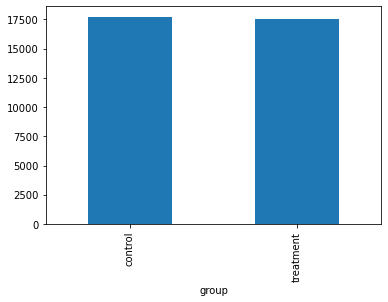

In [94]:
group_count.plot.bar()

In [95]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]


In [96]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


NameError: name 'nobs' is not defined

In [ ]:
# Creating the sampling distribution of difference in means 
means_diff = []
size = test.shape[0]
for _ in range(10000):
    sample = test.sample(size, replace = True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)


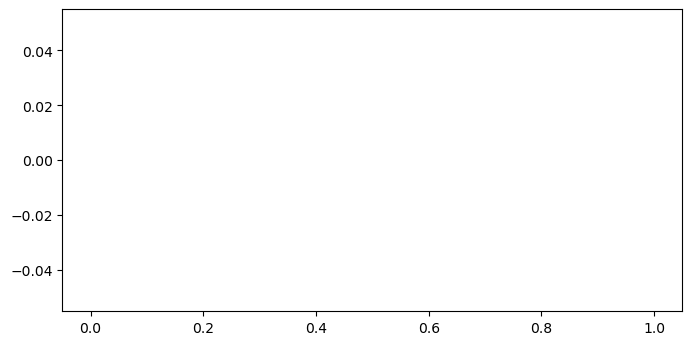

In [101]:
# Plotting the sampling distribution 
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()


In [90]:
# Simulate distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)


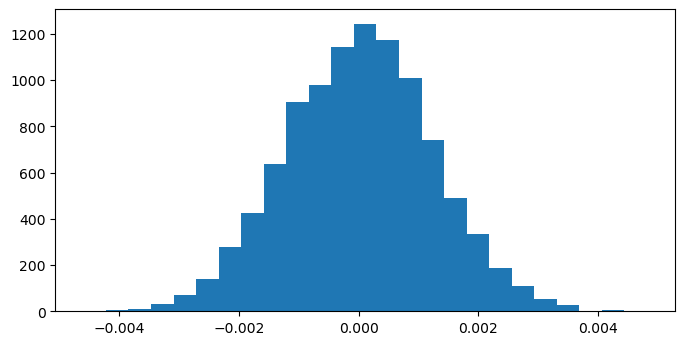

In [91]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()


In [92]:
# Plot observed statistic with the null distibution
control_mean = test[test["group"] == "control"]["converted"].mean()
treat_mean = test[test["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

NameError: name 'df2' is not defined

In [ ]:
# calculating the p value 
(null_vals > obs_diff).mean(

In [ ]:
import statsmodels.api as sm

convert_old = test[(test["converted"] == 1) & (test["landing_page"] == "old_page")]['user_id'].nunique()
convert_new = test[(test["converted"] == 1) & (test["landing_page"] == "new_page")]['user_id'].nunique()
n_old = df2[df["landing_page"] == "old_page"]['user_id'].nunique()
n_new = df2[df["landing_page"] == "new_page"]['user_id'].nunique()


In [ ]:
regression 


In [ ]:
# Creat the intercept 
test["intercept"] = 1
test.head()

In [ ]:
# Create ab_page column, which is 1 when an individual receives the treatment and 0 if control.
test["ab_page"] = test.group.apply(lambda x: 1 if (x == "treatment") else 0)
df2.head()

In [ ]:
# Instantiate and fit the regression model
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()
result.summary()

In [ ]:
# Merge the countries dataframe with df2 
countries.columns = ["user_id", "country"]
countries["user_id"] = countries["user_id"].astype(str)
df3 = test.merge(countries, on = "user_id", how = "left")
df3.head()

In [ ]:
# creating dummies for country and landing_page columns 
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

In [ ]:
# lest see if there is a relation between country and conversion
pd.pivot_table(data = df3, index = "country", values = "converted").sort_values(by = "converted", ascending = False) * 100
converted


In [ ]:
# Instantiate and fit the regression model with country as an additional variable: 'CA' is a baseline
model = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'UK','US']])
result = model.fit()
result.summary()

In [ ]:
# exponentiate the parameters to inteprete the result
np.exp(result.params)